In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

In [2]:
# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


In [3]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [4]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [5]:
contact_threshold = 250
esc_contact_maps = esc_maps_interp < 250
cnc_contact_maps = cnc_maps_interp < 250

In [6]:
def count_stack_contacts_per_viewpoint(contact_map):
    num_viewpoints, _ = contact_map.shape
    num_stack_array = np.zeros(num_viewpoints)
    for i in range(num_viewpoints):
        num_stack_array[i] = np.sum(contact_map[i, :]) - 1
    return num_stack_array

In [8]:
esc_stack_count = np.array([count_stack_contacts_per_viewpoint(x) for x in esc_contact_maps])
cnc_stack_count = np.array([count_stack_contacts_per_viewpoint(x) for x in cnc_contact_maps])

In [16]:
# Flatten the stack count array
esc_stack_count_flat = esc_stack_count.flatten()
cnc_stack_count_flat = cnc_stack_count.flatten()

In [45]:
def get_median_stack_id(contact_map):
    num_viewpoints, _ = contact_map.shape
    median_stack_id_array = np.zeros(num_viewpoints)
    for i in range(num_viewpoints):
        if np.sum(contact_map[i, :]) > 1:
            median_stack_id_array[i] = np.median(np.flatnonzero(contact_map[i, :]))
    return median_stack_id_array

In [46]:
esc_median_stack_id = np.array([get_median_stack_id(x) for x in esc_contact_maps])
cnc_median_stack_id = np.array([get_median_stack_id(x) for x in cnc_contact_maps])

In [47]:
# Reshape stack_id arrays such that it is a 1D array
esc_median_stack_id_flat = esc_median_stack_id.flatten()
cnc_median_stack_id_flat = cnc_median_stack_id.flatten()

In [48]:
# Add flatten arrays to the dataframe 
esc_df = pd.DataFrame({
    'viewpoint': np.tile(np.arange(80), esc_maps_interp_flat.shape[0]),
    'stack_count': esc_stack_count_flat,
    'median_stack_id': esc_median_stack_id_flat,
    'cell_type': 'ESC'
})


In [49]:
cnc_df = pd.DataFrame({
    'viewpoint': np.tile(np.arange(80), cnc_maps_interp_flat.shape[0]),
    'stack_count': cnc_stack_count_flat,
    'median_stack_id': cnc_median_stack_id_flat,
    'cell_type': 'CNC'
})

In [50]:
all_df = pd.concat([esc_df, cnc_df], axis=0)

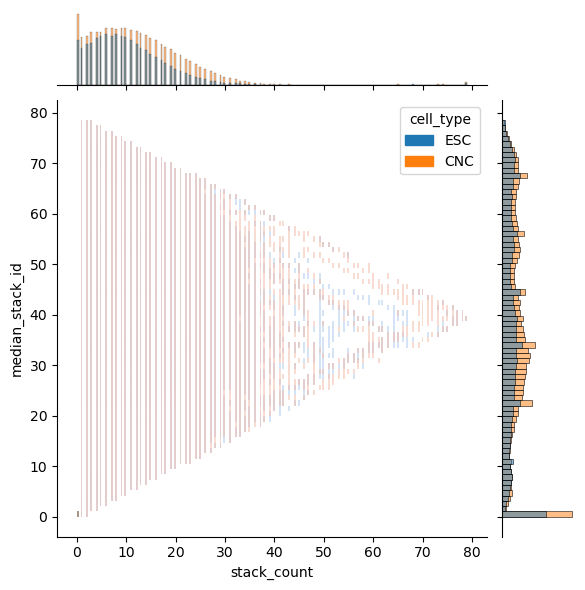

In [52]:
sns.jointplot(all_df, x='stack_count', y='median_stack_id', hue='cell_type', kind='hist',
            alpha=0.5)